### This notebook is for problem set 3 of the stochastic simulation course. We have picked the traveling salesman problem (TSP).

All graphs analyzed in this notebook are assumed to:
1. Be complete graphs (all nodes are adjacent to all other nodes)
2. Follow the triangle inequality (the shortest path between nodes is through the edge that connects them)
3. Symmetric (the path from A to B has the same length as B to A)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load in the provided graphs and optimal solutions

In [2]:
def load_data(file_path: str) -> pd.DataFrame:
    """Load the the nodes as defined in the TSP-Configurations folders in a dataframe.

    Args:
        file_path: The path to the file to load the data from.

    Returns:
        Dataframe with columns "Node", "X" and "Y", representing the node and its coordinates.
    """
    with open(file_path, "r") as file:
        lines = file.readlines()

    # Find the data by detecting the text 'NODE_COORD_SECTION'
    start_idx = lines.index("NODE_COORD_SECTION\n") + 1

    # Extract data until EOF
    data = []
    for line in lines[start_idx:]:
        if line.strip() == "EOF":
            break
        data.append(line.strip())

    # Convert the extracted data into a DataFrame
    df = pd.DataFrame(data=[map(int, line.split()) for line in data], columns=["Node", "X", "Y"])

    return df


def load_solutions(file_path: str) -> np.ndarray:
    """Load the the optimal TSP solutions as defined in the TSP-Configurations folders in a dataframe.

    Args:
        file_path: The path to the file to load the solutions from.

    Returns:
        Array containing the optimal path of the TSP.
    """
    with open(file_path, "r") as file:
        lines = file.readlines()

    # Find the data by detecting the text 'TOUR_SECTION'
    start_idx = lines.index("TOUR_SECTION\n") + 1

    # Extract data until -1
    data = []
    for line in lines[start_idx:]:
        if line.strip() == "-1":
            break
        data.append(line.strip())

    # Complete the cycle and convert into np array
    df = np.array(data+[data[0]], dtype=int)

    return df


small_tsp_data_path = "TSP-Configurations/eil51.tsp.txt"
small_tsp_solution_path = "TSP-Configurations/eil51.opt.tour.txt"
medium_tsp_data_path = "TSP-Configurations/a280.tsp.tx"
medium_tsp_solution_path = "TSP-Configurations/a280.opt.tour.txt"
large_tsp_data_path = "TSP-Configurations/pcb442.tsp.tx"
medium_tsp_solution_path = "TSP-Configurations/pcb442.opt.tour.txt"

cities = load_data(small_tsp_data_path)
print(cities.head())
opt_path = load_solutions(small_tsp_solution_path)
print(opt_path)

   Node   X   Y
0     1  37  52
1     2  49  49
2     3  52  64
3     4  20  26
4     5  40  30
[ 1 22  8 26 31 28  3 36 35 20  2 29 21 16 50 34 30  9 49 10 39 33 45 15
 44 42 40 19 41 13 25 14 24 43  7 23 48  6 27 51 46 12 47 18  4 17 37  5
 38 11 32  1]


### Generate an initial solution and calculate the cost

In [3]:
def generate_initial_path(graph_data: pd.DataFrame) -> np.ndarray:
    """Generate a solution of the TSP problem by taking the shortest path between each node.

    Args:
        graph_data: The dataset to generate the solution for.

    Returns:
        Array containing a (suboptimal) solution to the TSP.
    """
    # Extract nodes and coordinates
    nodes = graph_data["Node"].values
    coordinates = graph_data[["X", "Y"]].values
    num_nodes = len(nodes)

    # Initialize variables to keep count of which node has been visited
    visited = np.zeros(num_nodes, dtype=bool)  # Visited mask
    path = np.zeros(num_nodes + 1, dtype=int)  # Path array
    path[0] = nodes[0]  # Start at the first node
    visited[path[0] - 1] = True  # Mark the first node as visited

    for i in range(1, num_nodes):
        current_coords = coordinates[path[i - 1] - 1]  # Current node coordinates
        distances = np.linalg.norm(coordinates - current_coords, axis=1)  # Calculate distances
        distances[visited] = np.inf  # Mask visited nodes
        next_node = np.argmin(distances) + 1  # Find the nearest unvisited node
        path[i] = next_node  # Add to path
        visited[next_node - 1] = True  # Mark as visited

    # Complete the cycle by returning to the starting node
    path[-1] = path[0]

    return path


def perturb_path(path: np.ndarray) -> np.ndarray:
    """Generates a neighbor solution by swapping two nodes in the path.

    Args:
        solution: Current TSP path.

    Returns:
        A new TSP path with two nodes swapped.
    """
    # Copy the solution to avoid modifying the original
    neighbor = path.copy()
    # Select two distinct indices (excluding the start/end point)
    i, j = np.random.choice(len(path) - 1, size=2, replace=False)
    # Swap the selected nodes
    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
    return neighbor


def tsp_cost(graph_data: pd.DataFrame, solution: np.ndarray) -> float:
    """Calculates the cost of a solution to the TSP, which is defined as the total length of the path.

        Args:
            graph_data: The dataset to generate the solution for.
            solution: The path of the solution to the TSP.

        Returns:
            The cost of the solution.
    """
    # Extract the node coordinates
    coordinates = graph_data[["X", "Y"]].values

    # Get the coordinates of nodes in the solution
    path_coords = coordinates[solution - 1]

    # Calculate distances between consecutive nodes in the solution
    distances = np.linalg.norm(path_coords[:-1] - path_coords[1:], axis=1)

    return distances.sum()

initial_sol = generate_initial_path(cities)
print(initial_sol)
print(initial_sol.shape, opt_path.shape)
cost_initial_sol = tsp_cost(cities, initial_sol)
print(cost_initial_sol)
perturb_initial = perturb_path(initial_sol)
cost_perturbed_sol = tsp_cost(cities, perturb_initial)
print(cost_perturbed_sol)
cost_optimal_sol = tsp_cost(cities, opt_path)
print(cost_optimal_sol)

[ 1 32 11 38  5 49  9 50 16  2 29 21 34 30 10 39 33 45 15 44 37 17  4 18
 47 12 46 51 27 48  6 14 25 13 41 19 42 40 24 23  7 26  8 31 28  3 20 35
 36 22 43  1]
(52,) (52,)
513.610006884723
730.390148047134
429.983311983384


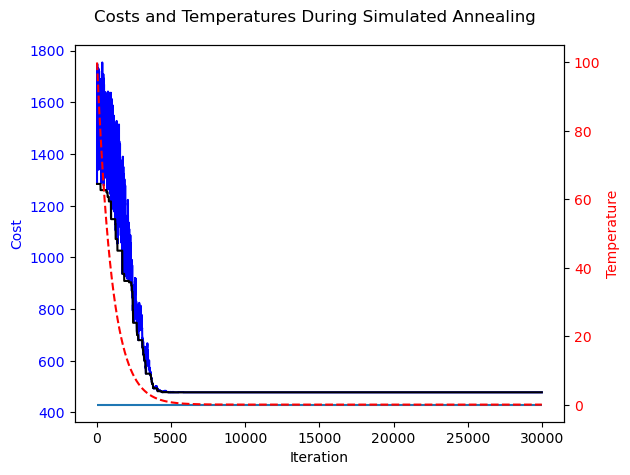

Best Solution: [ 6 23  7 43 24 14 25 13 18  0 46  1 22 28 31 26  8 48 27 49 10 39 33 45
 15 44 37 17 42 19 40 41  4 47 12  5 38 11 32  2  3 36 35 20 29 21 16  9
 30 34 50]
Best Cost: 477.5857337743199


In [21]:
def simulated_annealing_tsp(
    graph_data: pd.DataFrame,
    initial_solution: np.ndarray,
    initial_temperature: float,
    cooling_rate: float,
    num_iterations: int, 
    cooling_schedule: str, 
    MC_length: int
) -> tuple[np.ndarray, float]:
    """Applies the Metropolis algorithm with simulated annealing to solve the TSP.

    Args:
        graph_data: The dataset representing the TSP graph.
        initial_solution: The starting solution for the TSP.
        initial_temperature: Starting temperature for simulated annealing.
        cooling_rate: Cooling rate for the temperature.
        num_iterations: Number of iterations to perform.

    Returns:
        A tuple containing the best solution found and its cost.
    """
    current_solution = initial_solution
    current_cost = tsp_cost(graph_data, current_solution)

    best_solution = current_solution
    best_cost_list = np.zeros(num_iterations)
    best_cost = current_cost
    best_cost_list[0] = best_cost

    temperature = initial_temperature

    # Lists to store costs and temperatures for plotting
    costs = [current_cost]
    temperatures = [initial_temperature]

    for i in range(num_iterations):

        for _ in range(MC_length):

            # Generate a neighboring solution
            new_solution = perturb_path(current_solution)
            new_cost = tsp_cost(graph_data, new_solution)

            # Decide whether to accept the new solution
            if new_cost < current_cost or np.exp((current_cost - new_cost) / temperature) > np.random.rand():
                current_solution = new_solution
                current_cost = new_cost

                # Update the best solution found
                if current_cost < best_cost:
                    best_solution = current_solution
                    best_cost = current_cost

        best_cost_list[i] = best_cost
        # Cool down the temperature
        if cooling_schedule == "Geometric":
            temperature *= cooling_rate
        elif cooling_schedule == "Linear":
            temperature -= initial_temperature/num_iterations 
        elif cooling_schedule == "Logarithmic":
            temperature = initial_temperature/np.log(2+ i) # log(1+k) -> but k starts from 1
        
        # Save current cost and temperature for plotting
        costs.append(current_cost)
        temperatures.append(temperature)
        
        

    # Plot the costs and temperatures
    plot_costs_and_temperatures(costs, temperatures, best_cost_list)

    return best_solution, best_cost

def plot_costs_and_temperatures(costs: list, temperatures: list, best_cost_list: list):
    """Plots the costs and temperatures on the same graph with dual y-axes.

    Args:
        costs: List of costs during the optimization.
        temperatures: List of temperatures during the optimization.
    """
    fig, ax1 = plt.subplots()

    # Plot costs on the primary y-axis
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Cost", color="blue")
    ax1.plot(costs, color="blue", label="Cost")
    ax1.plot(best_cost_list, color="black")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.hlines(cost_optimal_sol, 0, len(costs))

    # Plot temperatures on the secondary y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel("Temperature", color="red")
    ax2.plot(temperatures, color="red", linestyle="--", label="Temperature")
    ax2.tick_params(axis="y", labelcolor="red")

    # Add title and legends
    fig.suptitle("Costs and Temperatures During Simulated Annealing")
    fig.tight_layout()
    plt.show()


initial_temperature = 100
cooling_rate = 0.999
num_iterations = 30000

best_solution, best_cost = simulated_annealing_tsp(
    cities, np.arange(len(cities)), initial_temperature, cooling_rate, num_iterations,
      "Geometric", 10 # 2nd was np.arange(52)
)

print("Best Solution:", best_solution)
print("Best Cost:", best_cost)

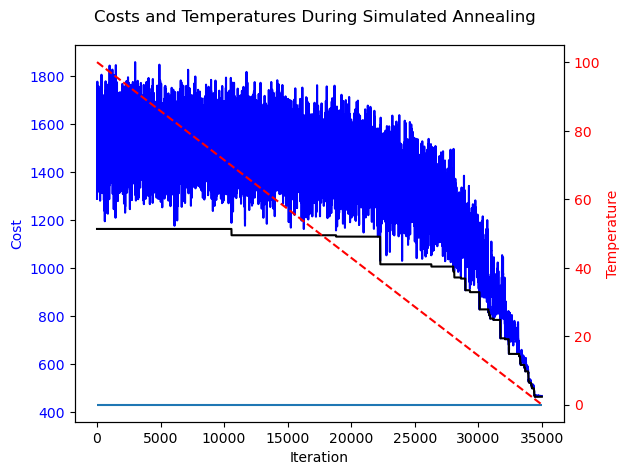

Best Solution: [40 13 41 19 42 44 15 45 33 39 10 49 38  9 30 34 16 11  5 46  0 27 48 26
  8  7 43 24 23  6 14 25 18 47  4 17 37 12 32  1 22 31 28  3 36 35 20  2
 29 21 50]
Best Cost: 462.7141564431563


In [26]:
initial_temperature = 100
cooling_rate = 0.999
num_iterations = 35000

best_solution, best_cost = simulated_annealing_tsp(
    cities, np.arange(len(cities)), initial_temperature, cooling_rate, num_iterations, 
    "Linear", 10 # 2nd was np.arange(52)
)

print("Best Solution:", best_solution)
print("Best Cost:", best_cost)

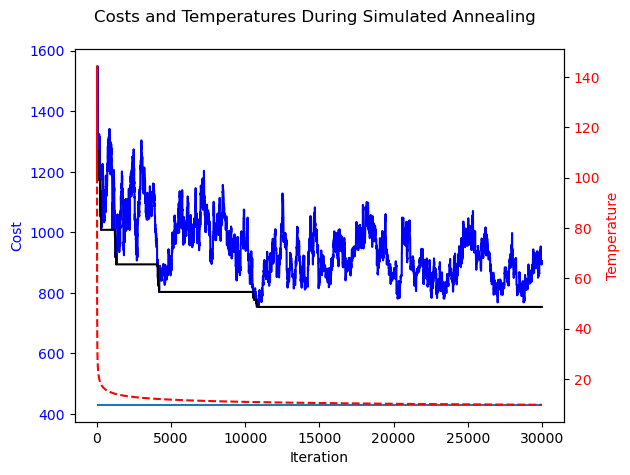

Best Solution: [25 24 14 16 38  5 15 45 33 34 30 49 46 12 47 18  4 13 40 19 42 27 21 32
  0  6  7 26 43 23 48  1  8 22 28 31 36 11  2  3 20 35 29  9 10 39 44 41
 17 37 50]
Best Cost: 753.1477439453475


In [28]:
initial_temperature = 100
cooling_rate = 0.999
num_iterations = 30000

best_solution, best_cost = simulated_annealing_tsp(
    cities, np.arange(len(cities)), initial_temperature, cooling_rate, num_iterations, 
    "Logarithmic", 1 # 2nd was np.arange(52)
)

print("Best Solution:", best_solution)
print("Best Cost:", best_cost)

In [11]:
def two_opt_once(path: np.ndarray) -> np.ndarray:
    """Perform a single 2-opt step on a TSP path.

    Args:
        path: Current TSP path as an array of node indices.
        coordinates: Numpy array of shape (num_nodes, 2) containing the coordinates of each node.

    Returns:
        A new TSP path after applying one 2-opt operation.
    """
    # Copy the path to avoid modifying the original
    new_path = path.copy()

    # Randomly select two positions in the path to perform the 2-opt swap
    pos_1, pos_2 = np.random.choice(range(1, len(path) - 1), size=2, replace=False)
    if pos_1 > pos_2:
        pos_1, pos_2 = pos_2, pos_1

    # Reverse the segment between pos_1 and pos_2
    new_path[pos_1:pos_2 + 1] = new_path[pos_1:pos_2 + 1][::-1]

    return new_path, new_path[pos_1], new_path[pos_2]

print(opt_path)
print(two_opt_once(opt_path))

[ 1 22  8 26 31 28  3 36 35 20  2 29 21 16 50 34 30  9 49 10 39 33 45 15
 44 42 40 19 41 13 25 14 24 43  7 23 48  6 27 51 46 12 47 18  4 17 37  5
 38 11 32  1]
(array([ 1, 22,  8, 26, 31, 28,  3, 36, 35, 20,  2, 29, 21, 16, 50, 34, 30,
        9, 49, 10, 39, 33, 45, 15, 44,  7, 43, 24, 14, 25, 13, 41, 19, 40,
       42, 23, 48,  6, 27, 51, 46, 12, 47, 18,  4, 17, 37,  5, 38, 11, 32,
        1]), 7, 42)
